<a href="https://colab.research.google.com/github/KianESoftware/Satellite-Image-Segmentation-Multiclass-/blob/main/Portfolio_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing the required library

In [1]:
!pip3 install torch torchvision tensorboard pytorch_lightning torchmetrics segmentation-models-pytorch

In [2]:
# 1) importing libraries and packages
#-------------------------------------------

import numpy as np
import os
import torch
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
from torchmetrics import F1Score
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import MulticlassPrecision
from torchmetrics import AveragePrecision
from torchmetrics.classification import MulticlassRecall , MulticlassF1Score
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torchvision.utils as vutils
import torch.nn as nn
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import LambdaLR
import albumentations as A

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the data



In [4]:
simple_folder_path = '/****/*****/****'
complex_folder_path = '/****/*****/****'
very_complex_folder_path = '/****/*****/****'
validation_floder_path = '/****/*****/****'

In [5]:
# checking if the data is loaded correctly

len(os.listdir(simple_folder_path)+os.listdir(complex_folder_path)+os.listdir(very_complex_folder_path)+os.listdir(validation_floder_path))

1606

In [6]:
# initializing lists to store paths

simple_images=[]
simple_masks=[]

complex_images=[]
complex_masks=[]

very_complex_images=[]
very_complex_masks=[]

validation_images=[]
validation_masks=[]

In [7]:
# taking images and masks into their corresponding lists

for simple_item in os.listdir(simple_folder_path):
  if simple_item.endswith('mask.png'):
    simple_masks.append(os.path.join(simple_folder_path,simple_item))
  elif simple_item.endswith('sat.jpg'):
    simple_images.append(os.path.join(simple_folder_path,simple_item))

for complex_item in os.listdir(complex_folder_path):
  if complex_item.endswith('mask.png'):
    complex_masks.append(os.path.join(complex_folder_path,complex_item))
  elif complex_item.endswith('sat.jpg'):
    complex_images.append(os.path.join(complex_folder_path,complex_item))


for very_complex_item in os.listdir(very_complex_folder_path):
  if very_complex_item.endswith('mask.png'):
    very_complex_masks.append(os.path.join(very_complex_folder_path,very_complex_item))
  elif very_complex_item.endswith('sat.jpg'):
    very_complex_images.append(os.path.join(very_complex_folder_path,very_complex_item))


for validation_item in os.listdir(validation_floder_path):
  if validation_item.endswith('mask.png'):
    validation_masks.append(os.path.join(validation_floder_path,validation_item))
  elif validation_item.endswith('sat.jpg'):
    validation_images.append(os.path.join(validation_floder_path,validation_item))

In [9]:
# sorting all data to ensure images and masks match

sorted_simple_images = sorted(simple_images)
sorted_simple_masks = sorted(simple_masks)

sorted_complex_images = sorted(complex_images)
sorted_complex_masks = sorted(complex_masks)

sorted_very_complex_images = sorted(very_complex_images)
sorted_very_complex_masks = sorted(very_complex_masks)

print(len(sorted_simple_images))
print(len(sorted_simple_masks),'\n')

print(len(sorted_complex_images))
print(len(sorted_complex_masks),'\n')

print(len(sorted_very_complex_images))
print(len(sorted_very_complex_masks),'\n')



print(sorted_simple_images[0])
print(sorted_simple_masks[0],'\n')

print(sorted_simple_images[0])
print(sorted_simple_masks[0],'\n')

print(sorted_simple_images[-1])
print(sorted_simple_masks[-1],'\n')



print(sorted_complex_images[0])
print(sorted_complex_masks[0],'\n')

print(sorted_complex_images[-1])
print(sorted_complex_masks[-1],'\n')



print(sorted_very_complex_images[0])
print(sorted_very_complex_masks[0],'\n')

print(sorted_very_complex_images[-1])
print(sorted_very_complex_masks[-1],'\n')

599
599 

72
72 

51
51 

/content/drive/MyDrive/MyDeepGlobeDataset/SimpleV2/100694_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/SimpleV2/100694_mask.png 

/content/drive/MyDrive/MyDeepGlobeDataset/SimpleV2/100694_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/SimpleV2/100694_mask.png 

/content/drive/MyDrive/MyDeepGlobeDataset/SimpleV2/995492_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/SimpleV2/995492_mask.png 

/content/drive/MyDrive/MyDeepGlobeDataset/ComplexV2/114473_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/ComplexV2/114473_mask.png 

/content/drive/MyDrive/MyDeepGlobeDataset/ComplexV2/998002_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/ComplexV2/998002_mask.png 

/content/drive/MyDrive/MyDeepGlobeDataset/VeryComplexV2/115444_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/VeryComplexV2/115444_mask.png 

/content/drive/MyDrive/MyDeepGlobeDataset/VeryComplexV2/997521_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/VeryComplexV2/997521_mask.png 



# Reading the data

reading data using OpenCV

In [10]:
def read_data(data_path_list,type):      # a function to read data

  the_data=[]

  for i in data_path_list:

    image = cv2.imread(i)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if type != 'very_complex':
      image = cv2.resize(image, (256, 256))

    the_data.append(image)

  return the_data

In [11]:
# reading the data

simple_images_batch1 = read_data(sorted_simple_images[0:300],'simple')
simple_masks_batch1 = read_data(sorted_simple_masks[0:300],'simple')

simple_images_batch2 = read_data(sorted_simple_images[300:],'simple')
simple_masks_batch2 = read_data(sorted_simple_masks[300:],'simple')


complex_images = read_data(sorted_complex_images,'complex')
complex_masks = read_data(sorted_complex_masks,'complex')

very_complex_images = read_data(sorted_very_complex_images,'very_complex')
very_complex_masks = read_data(sorted_very_complex_masks,'very_complex')

300
300
299
299
599
599


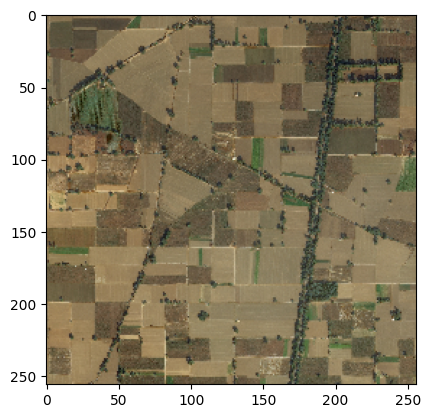

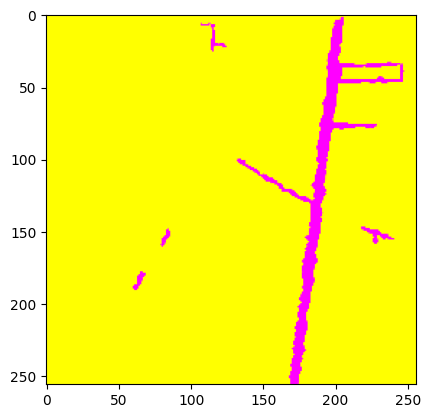

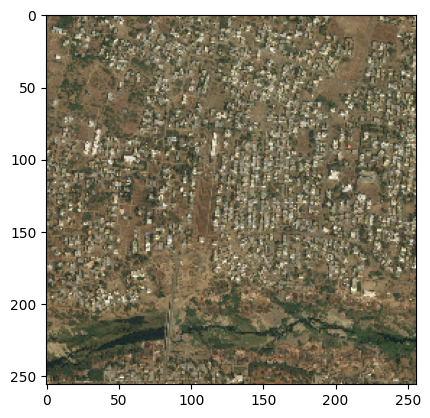

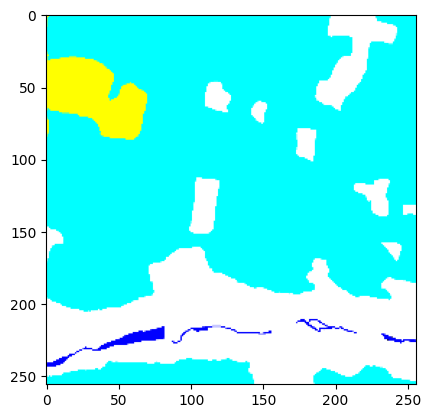

In [12]:
# check to see if data is read correctly

print(len(simple_images_batch1))
print(len(simple_masks_batch1))

print(len(simple_images_batch2))
print(len(simple_masks_batch2))


print(len(simple_images_batch1)+len(simple_images_batch2))
print(len(simple_masks_batch1)+len(simple_masks_batch2))


plt.imshow(simple_images_batch1[0])
plt.show()
plt.imshow(simple_masks_batch1[0])
plt.show()
plt.imshow(simple_images_batch2[0])
plt.show()
plt.imshow(simple_masks_batch2[0])
plt.show()


# Data Augmentation

simple images ==> excluded from augmentation pipline

complex images ==> each complex image and its corresponding mask will have 3 augmented versions:

  1.horizantally flipped

  2.vertically flipped

  3.transposed


very complex images ==> each very complex image and its corresponding mask will be divided into 4 patches and each patch will have 3 versions as explained above




In [13]:
#Augmentation


def augment_data(data,mask,type):

  augmented_data=[]
  augmented_masks=[]

  if type == 'complex':

    augmentation_1 = A.HorizontalFlip(p=1)
    augmentation_2 = A.VerticalFlip(p=1)
    augmentation_3 = A.Transpose(p=1)

    for i in range(len(data)):

      augmented_1 = augmentation_1(image=data[i],mask=mask[i])
      augmented_2 = augmentation_2(image=data[i],mask=mask[i])
      augmented_3 = augmentation_3(image=data[i],mask=mask[i])


      augmented_data.append(augmented_1['image'])
      augmented_masks.append(augmented_1['mask'])

      augmented_data.append(augmented_2['image'])
      augmented_masks.append(augmented_2['mask'])

      augmented_data.append(augmented_3['image'])
      augmented_masks.append(augmented_3['mask'])



  elif type == 'very_complex':

    augmentation_1 = A.HorizontalFlip(p=1)
    augmentation_2 = A.VerticalFlip(p=1)
    augmentation_3 = A.Transpose(p=1)

    for j in range(len(data)):



      patch1 = data[j][0:1224,0:1224]
      patch2 = data[j][0:1224,1224:]
      patch3 = data[j][1224:,0:1224]
      patch4 = data[j][1224:,1224:]

      patch_mask1 = mask[j][0:1224,0:1224]
      patch_mask2 = mask[j][0:1224,1224:]
      patch_mask3 = mask[j][1224:,0:1224]
      patch_mask4 = mask[j][1224:,1224:]

      patch1_resized = cv2.resize(patch1,(256,256))
      patch2_resized = cv2.resize(patch2,(256,256))
      patch3_resized = cv2.resize(patch3,(256,256))
      patch4_resized = cv2.resize(patch4,(256,256))

      patch_mask1_resized = cv2.resize(patch_mask1,(256,256))
      patch_mask2_resized = cv2.resize(patch_mask2,(256,256))
      patch_mask3_resized = cv2.resize(patch_mask3,(256,256))
      patch_mask4_resized = cv2.resize(patch_mask4,(256,256))

      augmented_data.append(patch1_resized)
      augmented_masks.append(patch_mask1_resized)

      augmented_data.append(patch2_resized)
      augmented_masks.append(patch_mask2_resized)

      augmented_data.append(patch3_resized)
      augmented_masks.append(patch_mask3_resized)

      augmented_data.append(patch4_resized)
      augmented_masks.append(patch_mask4_resized)

      second_augmented_1 = augmentation_1(image=patch1_resized,mask=patch_mask1_resized)
      second_augmented_2 = augmentation_2(image=patch1_resized,mask=patch_mask1_resized)
      second_augmented_3 = augmentation_3(image=patch1_resized,mask=patch_mask1_resized)

      second_augmented_4 = augmentation_1(image=patch2_resized,mask=patch_mask2_resized)
      second_augmented_5 = augmentation_2(image=patch2_resized,mask=patch_mask2_resized)
      second_augmented_6 = augmentation_3(image=patch2_resized,mask=patch_mask2_resized)

      second_augmented_7 = augmentation_1(image=patch3_resized,mask=patch_mask3_resized)
      second_augmented_8 = augmentation_2(image=patch3_resized,mask=patch_mask3_resized)
      second_augmented_9 = augmentation_3(image=patch3_resized,mask=patch_mask3_resized)

      second_augmented_10 = augmentation_1(image=patch4_resized,mask=patch_mask4_resized)
      second_augmented_11 = augmentation_2(image=patch4_resized,mask=patch_mask4_resized)
      second_augmented_12 = augmentation_3(image=patch4_resized,mask=patch_mask4_resized)

      augmented_data.append(second_augmented_1['image'])
      augmented_masks.append(second_augmented_1['mask'])

      augmented_data.append(second_augmented_2['image'])
      augmented_masks.append(second_augmented_2['mask'])

      augmented_data.append(second_augmented_3['image'])
      augmented_masks.append(second_augmented_3['mask'])

      augmented_data.append(second_augmented_4['image'])
      augmented_masks.append(second_augmented_4['mask'])

      augmented_data.append(second_augmented_5['image'])
      augmented_masks.append(second_augmented_5['mask'])

      augmented_data.append(second_augmented_6['image'])
      augmented_masks.append(second_augmented_6['mask'])

      augmented_data.append(second_augmented_7['image'])
      augmented_masks.append(second_augmented_7['mask'])

      augmented_data.append(second_augmented_8['image'])
      augmented_masks.append(second_augmented_8['mask'])

      augmented_data.append(second_augmented_9['image'])
      augmented_masks.append(second_augmented_9['mask'])

      augmented_data.append(second_augmented_10['image'])
      augmented_masks.append(second_augmented_10['mask'])

      augmented_data.append(second_augmented_11['image'])
      augmented_masks.append(second_augmented_11['mask'])

      augmented_data.append(second_augmented_12['image'])
      augmented_masks.append(second_augmented_12['mask'])





  return augmented_data,augmented_masks


In [14]:
complex_augmented_images,complex_augmented_masks = augment_data(complex_images,complex_masks,'complex')

print('the length of augmentes complex images is:',len(complex_augmented_images))
print('the length of augmentes complex masks is:',len(complex_augmented_masks))

the length of augmentes complex images is: 216
the length of augmentes complex masks is: 216


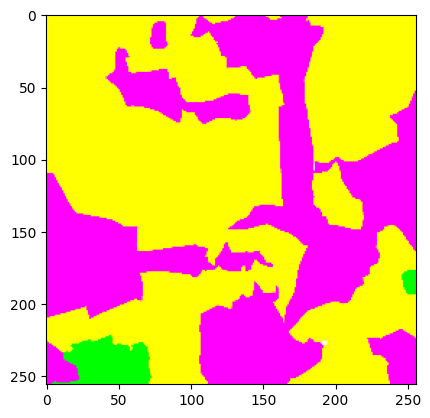

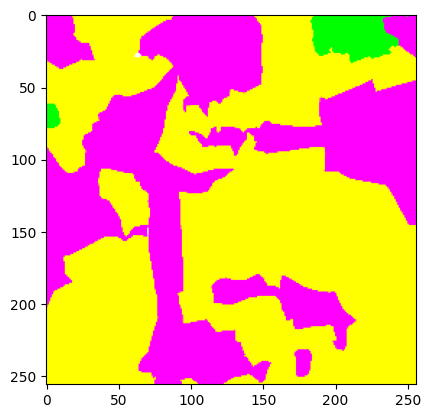

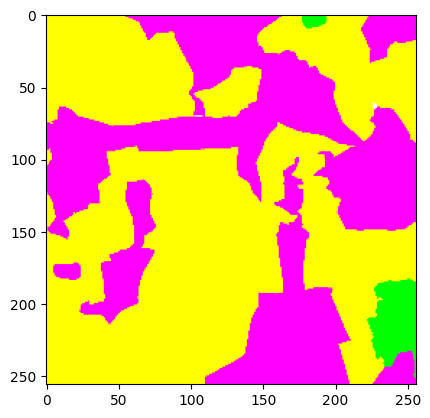

In [15]:
# vizualizing the augmentation results

plt.imshow(complex_augmented_masks[0])
plt.show()

plt.imshow(complex_augmented_masks[1])
plt.show()

plt.imshow(complex_augmented_masks[2])
plt.show()

the length of augmented very complex images is: 816
the length of augmented very complex masks is: 816


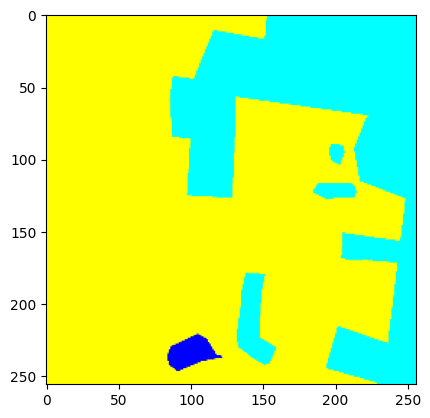

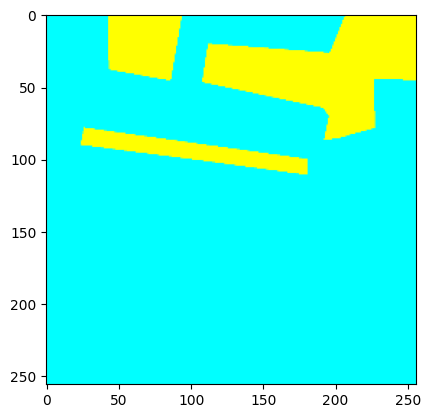

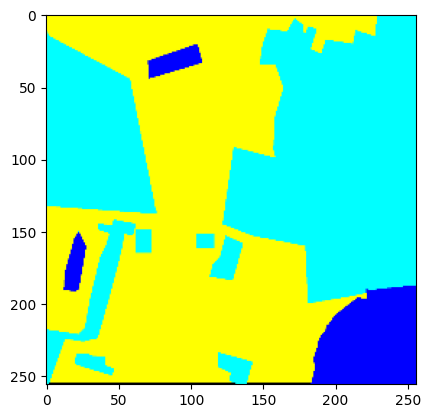

In [16]:
very_complex_augmented_images,very_complex_augmented_masks = augment_data(very_complex_images,very_complex_masks,'very_complex')

print('the length of augmented very complex images is:',len(very_complex_augmented_images))
print('the length of augmented very complex masks is:',len(very_complex_augmented_masks))

plt.imshow(very_complex_augmented_masks[0])
plt.show()

plt.imshow(very_complex_augmented_masks[1])
plt.show()

plt.imshow(very_complex_augmented_masks[2])
plt.show()



In [18]:

final_augmented_complex_images = complex_augmented_images + complex_images
final_augmented_complex_masks = complex_augmented_masks + complex_masks

print("======Verification======\n")
print('the number of original complex images + augmented complex images equals:',len(final_augmented_complex_images))
print('the number of original complex masks + augmented complex masks equals:',len(final_augmented_complex_masks))



======Verification======

the number of original complex images + augmented complex images equals: 288
the number of original complex masks + augmented complex masks equals: 288


# Pre-processing

preprocesing includes:

1. normalizing

2. one-hot encoding

In [19]:
def preprocess_normalize_encode(data,image_or_mask,number_of_classes):

  if image_or_mask == 'image':
    data_array = np.array(data)
    data_array = data_array / 255.0
    return data_array


  if image_or_mask =='mask':

    class_mapping = {
    (0, 255, 255): 0,   # Urban Land
    (255, 255, 0): 1,   # Agriculture Land
    (255, 0, 255): 2,   # Rangeland
    (0, 255, 0): 3,     # Forest Land
    (0, 0, 255): 4,     # Water
    (255, 255, 255): 5, # Barren Land
    (0, 0, 0): 6        # Unknown
    }

    encoded_masks = np.zeros((len(data),256, 256, len(class_mapping)))

    for counter, mask in enumerate(data):
      for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            pixel_rgb = tuple(mask[x, y])
            if pixel_rgb in class_mapping:
                class_index = class_mapping[pixel_rgb]
                encoded_masks[counter, x, y, class_index] = 1

    return encoded_masks


In [20]:
preprocessed_simple_images_batch1 = preprocess_normalize_encode(simple_images_batch1,'image',7)
preprocessed_simple_masks_batch1 = preprocess_normalize_encode(simple_masks_batch1,'mask',7)

print("===========Verification========")
print('shape:',preprocessed_simple_images_batch1.shape)
print('shape:',preprocessed_simple_masks_batch1.shape)


===========Verification========
shape: (300, 256, 256, 3)
shape: (300, 256, 256, 7)


In [21]:

preprocessed_simple_images_batch2 = preprocess_normalize_encode(simple_images_batch2,'image',7)
preprocessed_simple_masks_batch2 = preprocess_normalize_encode(simple_masks_batch2,'mask',7)

print("===========Verification========")
print('shape:',preprocessed_simple_images_batch2.shape)
print('shape:',preprocessed_simple_masks_batch2.shape)



===========Verification========
shape: (299, 256, 256, 3)
shape: (299, 256, 256, 7)


In [22]:
preprocessed_complex_images=preprocess_normalize_encode(final_augmented_complex_images,'image',7)
preprocessed_complex_masks=preprocess_normalize_encode(final_augmented_complex_masks,'mask',7)

print("===========Verification========")
print('shape:',preprocessed_complex_images.shape)
print('shape:',preprocessed_complex_masks.shape)



===========Verification========
shape: (288, 256, 256, 3)
shape: (288, 256, 256, 7)


In [24]:
preprocessed_very_complex_images=preprocess_normalize_encode(very_complex_augmented_images,'image',7)
preprocessed_very_complex_masks=preprocess_normalize_encode(very_complex_augmented_masks,'mask',7)

print("===========Verification========")
print('shape:',preprocessed_very_complex_images.shape)
print('shape:',preprocessed_very_complex_masks.shape)

===========Verification========
shape: (816, 256, 256, 3)
shape: (816, 256, 256, 7)


In [25]:
X = np.concatenate((preprocessed_simple_images_batch1,preprocessed_very_complex_images,preprocessed_simple_images_batch2,preprocessed_complex_images,),axis=0)

y=np.concatenate((preprocessed_simple_masks_batch1,preprocessed_very_complex_masks,preprocessed_simple_masks_batch2,preprocessed_complex_masks,),axis=0)

print("===========Verification========")
print('shape:',X.shape)
print('shape:',y.shape)

===========Verification========
shape: (1703, 256, 256, 3)
shape: (1703, 256, 256, 7)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("===========Verification========")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

===========Verification========
(1277, 256, 256, 3)
(426, 256, 256, 3)
(1277, 256, 256, 7)
(426, 256, 256, 7)


# Pytorch workflow

In [27]:
# preparing the data for the pytorch workflow

X_train_torch_tensor = torch.tensor(X_train, dtype=torch.float32)
X_train_torch_tensor  = X_train_torch_tensor .permute(0, 3, 1, 2)
X_test_torch_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_torch_tensor = X_test_torch_tensor.permute(0, 3, 1, 2)
y_train_torch_tesnor = torch.tensor(y_train, dtype=torch.float32)
y_train_torch_tesnor = y_train_torch_tesnor.permute(0, 3, 1, 2)
y_test_torch_tensor = torch.tensor(y_test, dtype=torch.float32)
y_test_torch_tensor = y_test_torch_tensor.permute(0, 3, 1, 2)

In [28]:
# dataset in pytorch workflow

class DeepGlobePytorchDataset(Dataset):
  def __init__(self, images, masks):
    self.images = images
    self.masks = masks

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx)  :
    return self.images[idx], self.masks[idx]

In [29]:
train_pytorchDataset = DeepGlobePytorchDataset(X_train_torch_tensor, y_train_torch_tesnor)
val_pytorchDataset = DeepGlobePytorchDataset(X_test_torch_tensor, y_test_torch_tensor)

train_dataloader = DataLoader(train_pytorchDataset, batch_size=32, shuffle=True)

val_dataloader = DataLoader(val_pytorchDataset, batch_size=32, shuffle=False)

# Implementing U-net from segmentation models pytorch

  Architecture : standard U-net

  Encoder : resnet50 pretrained on Imagenet

  Loss function : combined loss function ( 1*CrossEntropy + 1.5* Dice loss)

  Optimizer : SGD with momentum=0.9 and weight_decay=1e-4



In [30]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7,
)

In [31]:
# combined loss function

ce_loss_fn = torch.nn.CrossEntropyLoss()
dice_loss_fn = smp.losses.DiceLoss(mode='multiclass', classes=[0,1,2,3,4,5], log_loss=False, from_logits=True, smooth=0.0, ignore_index=6, eps=1e-07)


def loss_fn(pred, target, weight_ce=1.0, weight_dice=1.5):
    ce_loss = ce_loss_fn(pred, target)
    dice_loss = dice_loss_fn(pred, target)


    total_loss = (ce_loss * weight_ce )+ (dice_loss * weight_dice)

    return total_loss

In [34]:
def poly_decay(epoch):
    max_epochs = 50  # Match this with your total number of epochs
    base_lr = 0.01  # Initial learning rate
    power = 0.9  # Power parameter for the 'poly' schedule
    return (1 - epoch / float(max_epochs)) ** power

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Create the learning rate scheduler
lr_scheduler = LambdaLR(optimizer, lr_lambda=poly_decay)

# Metrics

defining the metrics using torchmetrics

In [35]:
# Setting metrics from torchmetrics

IoU = MeanIoU(num_classes=7, per_class=True)
mIoU = MeanIoU(num_classes=7)
Recall = MulticlassRecall(num_classes=7,average='macro',ignore_index = 6)
Recall_per_class = MulticlassRecall(num_classes=7,average=None,ignore_index = 6)
Precision = MulticlassPrecision(num_classes=7,average='macro',ignore_index=6)
Precision_per_class = MulticlassPrecision(num_classes=7,average=None,ignore_index=6)
F1 = MulticlassF1Score(num_classes=7,average='macro',ignore_index= 6)
F1_per_class = MulticlassF1Score(num_classes=7,average=None,ignore_index= 6)

# Training

training the model with epochs set to 50

In [36]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    train_loss = 0.0
    all_preds = []
    all_labels = []

    for images, masks in dataloader:
      images = images.to(device)
      masks = masks.to(device)

      if masks.shape[1] == 7:
        masks = masks.argmax(dim=1)  # This is correct, converting one-hot to class indices

      optimizer.zero_grad()
      predictions = model(images)
      loss = loss_fn(predictions, masks)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      all_preds.append(predictions.detach().cpu())
      all_labels.append(masks.detach().cpu())

    train_loss /= len(dataloader)

# Concatenate predictions and labels
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

# Ensure predictions are in the correct format (class indices)
    all_preds = all_preds.argmax(dim=1)
    preds_flat = all_preds.view(-1)
    targets_flat = all_labels.view(-1)

    train_miou = mIoU(all_preds, all_labels)  # Now both should have shape [N, 256, 256]
    train_iou = IoU(all_preds,all_labels)
    train_precision = Precision(all_preds, all_labels)
    train_precision_per_class =   Precision_per_class(all_preds, all_labels)
    train_recall = Recall(all_preds, all_labels)
    train_recall_per_class = Recall_per_class(all_preds, all_labels)
    train_f1 = F1(all_preds, all_labels)
    train_f1_per_class = F1_per_class(all_preds, all_labels)

    #average_precision_train = Average_Precision(all_preds, all_labels)

    return train_loss, train_miou, train_iou , train_precision,train_precision_per_class,train_recall,train_recall_per_class,train_f1,train_f1_per_class #average_precision_train


def validate(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in dataloader:
          images = images.to(device)
          masks = masks.to(device)

          if masks.shape[1] == 7:
             masks = masks.argmax(dim=1)  # This is correct, converting one-hot to class indices

          #optimizer.zero_grad()
          predictions = model(images)
          loss = loss_fn(predictions, masks)
          #loss.backward()
          #optimizer.step()

          val_loss += loss.item()
          all_preds.append(predictions.detach().cpu())
          all_labels.append(masks.detach().cpu())

        val_loss /= len(dataloader)

# Concatenate predictions and labels
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

# Ensure predictions are in the correct format (class indices)
        all_preds = all_preds.argmax(dim=1)
        #all_preds = all_preds.argmax(dim=1)
        preds_flat = all_preds.view(-1)
        targets_flat = all_labels.view(-1)

        miou = mIoU(all_preds, all_labels)  # Now both should have shape [N, 256, 256]
        iou = IoU(all_preds,all_labels)
        precision = Precision(all_preds, all_labels)
        precision_per_class =   Precision_per_class(all_preds, all_labels)
        recall = Recall(all_preds, all_labels)
        recall_per_class = Recall_per_class(all_preds, all_labels)

        f1 = F1(all_preds, all_labels)
        f1_per_class = F1_per_class(all_preds, all_labels)


        #average_precision = Average_Precision(all_preds, all_labels)

        return val_loss, miou ,iou, precision ,precision_per_class,recall,recall_per_class, f1 ,f1_per_class #average_precision

# Main training loop
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(50):
    train_loss, train_miou,train_iou , train_precision,train_precision_per_class,train_recall,train_recall_per_class ,train_f1,train_f1_per_class  = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device)
    val_loss, val_miou ,val_iou, val_precision ,val_precision_per_class,val_recall,val_recall_per_class, val_f1 ,val_f1_per_class  = validate(model, val_dataloader, loss_fn, device)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('MIoU/train', train_miou, epoch)
    #writer.add_scalar('IoU/train', train_iou, epoch)
    writer.add_scalar('Precision/train',train_precision, epoch)
    writer.add_scalar('Recall/train',train_recall, epoch)
    writer.add_scalar('F1/train',train_f1, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('MIoU/val', val_miou, epoch)
    #writer.add_scalar('IoU/val', val_iou, epoch)
    writer.add_scalar('Precision/val',val_precision, epoch)
    writer.add_scalar('Recall/val',val_recall, epoch)
    writer.add_scalar('F1/val',val_f1, epoch)

    lr_scheduler.step()

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    #print(f"Current learning rate: {current_lr:.6f}")

    print("\n=============================================\n")
    print(f"Epoch {epoch+1}/{50}")
    print('\ntrain loss:',train_loss, ' train miou:',train_miou,' train iou: ',train_iou , ' train precision: ',train_precision,' train precision per class: ',train_precision_per_class,' train recall:',train_recall,' train recall per class: ',train_recall_per_class ,' train f1:',train_f1,' train f1 per class:',train_f1_per_class)
    #print("Train Loss:",train_loss, "Train MIoU:", train_miou,"Train IoU:" , train_iou,'train preciison:',train_precision,"Train Recall:", train_recall,'train F1 score:', train_f1, )
    print("\n")
    print("Val Loss:", val_loss, " Val MIoU:", val_miou," Val IoU:" ,val_iou,' val preciison is :',val_precision,' val precision per class:',val_precision_per_class," Val Recall:", val_recall, ' val recall per class:',val_recall_per_class,' val f1 score :', val_f1,' val f1 per class:', val_f1_per_class )




Epoch 1/50

train loss: 2.2492307901382445  train miou: tensor(0.1211)  train iou:  tensor([1.8325e-01, 4.3599e-01, 7.8555e-02, 5.8173e-02, 5.2853e-02, 3.8733e-02,
        1.1343e-04])  train precision:  tensor(0.3922)  train precision per class:  tensor([0.5382, 0.6508, 0.3636, 0.5531, 0.3166, 0.3231, 0.0000])  train recall: tensor(0.3678)  train recall per class:  tensor([0.5829, 0.7808, 0.2012, 0.4906, 0.3030, 0.2160, 0.0000])  train f1: tensor(0.3739)  train f1 per class: tensor([0.5597, 0.7099, 0.2591, 0.5200, 0.3097, 0.2589, 0.0000])


Val Loss: 1.813730307987758  Val MIoU: tensor(0.1724)  Val IoU: tensor([0.2731, 0.4705, 0.1569, 0.0905, 0.1294, 0.0864, 0.0000])  val preciison is : tensor(0.6388)  val precision per class: tensor([0.7730, 0.8145, 0.4775, 0.7884, 0.4780, 0.5013, 0.0000])  Val Recall: tensor(0.6707)  val recall per class: tensor([0.7348, 0.7777, 0.4328, 0.6731, 0.8287, 0.5771, 0.0000])  val f1 score : tensor(0.6454)  val f1 per class: tensor([0.7534, 0.7957, 0.454

In [37]:
torch.save(model.state_dict(), '/****/***/Portfolio_Unet.pth')

# Evaluation

Evaluating the model performance

In [38]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7,
)

model.load_state_dict(torch.load('/****/***/Portfolio_Unet.pth'))
model.eval()

<ipython-input-38-2ffc17239fe2>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Portfolio_Unet.pth'))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [40]:
# prepairing test set


sorted_validation_images = sorted(validation_images)
sorted_validation_masks = sorted(validation_masks)

print(sorted_validation_images[0])
print(sorted_validation_masks[0])
print('---------------------------')
print(sorted_validation_images[10])
print(sorted_validation_masks[10])
print('---------------------------')
print(sorted_validation_images[-1])
print(sorted_validation_masks[-1])


val_images = read_data(sorted_validation_images,'val')
val_masks = read_data(sorted_validation_masks,'val')

preprocessed_val_images = preprocess_normalize_encode(val_images,'image',7)
preprocessed_val_masks = preprocess_normalize_encode(val_masks,'mask',7)

X_val_torch_tensor = torch.tensor(preprocessed_val_images, dtype=torch.float32)
X_val_torch_tensor  = X_val_torch_tensor .permute(0, 3, 1, 2)

y_val_torch_tesnor = torch.tensor(preprocessed_val_masks, dtype=torch.float32)
y_val_torch_tesnor = y_val_torch_tesnor.permute(0, 3, 1, 2)


print(X_val_torch_tensor.shape)

print(y_val_torch_tesnor.shape)

test_pytorchDataset = DeepGlobePytorchDataset(X_val_torch_tensor, y_val_torch_tesnor)
test_dataloader = DataLoader(test_pytorchDataset, batch_size=32, shuffle=False)


/content/drive/MyDrive/MyDeepGlobeDataset/ValidationV2/10452_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/ValidationV2/10452_mask.png
---------------------------
/content/drive/MyDrive/MyDeepGlobeDataset/ValidationV2/192602_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/ValidationV2/192602_mask.png
---------------------------
/content/drive/MyDrive/MyDeepGlobeDataset/ValidationV2/990617_sat.jpg
/content/drive/MyDrive/MyDeepGlobeDataset/ValidationV2/990617_mask.png
torch.Size([81, 3, 256, 256])
torch.Size([81, 7, 256, 256])


In [41]:
all_test_preds = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

final_IoU = MeanIoU(num_classes=7, per_class=True).to(device)
final_mIoU = MeanIoU(num_classes=7).to(device)
final_Recall = MulticlassRecall(num_classes=7,average='macro',ignore_index = 6).to(device)
final_Recall_per_class = MulticlassRecall(num_classes=7,average=None,ignore_index = 6).to(device)
final_Precision = MulticlassPrecision(num_classes=7,average='macro',ignore_index=6).to(device)
final_Precision_per_class = MulticlassPrecision(num_classes=7,average=None,ignore_index=6).to(device)
final_F1 = MulticlassF1Score(num_classes=7,average='macro',ignore_index= 6).to(device)
final_F1_per_class = MulticlassF1Score(num_classes=7,average=None,ignore_index= 6).to(device)


with torch.no_grad():  # Disable gradient calculation for inference
    for images,masks in test_dataloader:
        images = images.to('cpu')

        # Get model predictions
        predictions = model(images)

        # Convert to class indices
        my_preds = predictions.argmax(dim=1)  # Shape: [batch_size, height, width]

        #if masks.shape[1] == 7:  # Assuming 7 classes
            #masks = masks.argmax(dim=1)

        # Accumulate predictions for metric calculation
        all_test_preds.append(my_preds.cpu())  # Move to CPU and store

print(all_test_preds[0].shape)
print(y_val_torch_tesnor.shape)



# Concatenate all predictions
all_test_preds = torch.cat(all_test_preds, dim=0).to(device)
y_val_torch_tesnor=y_val_torch_tesnor.argmax(dim=1).to(device)
# If you have ground truth labels for unseen data (optional)
# unseen_labels = [...]  # Load or generate your ground truth labels here
# Calculate metrics
# miou_metric.update(all_preds.to(device), unseen_labels.to(device))
# precision_metric.update(all_preds.to(device), unseen_labels.to(device))
# recall_metric.update(all_preds.to(device), unseen_labels.to(device))
# f1_metric.update(all_preds.to(device), unseen_labels.to(device))
print('[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]')
print(all_test_preds[0].shape)
print(y_val_torch_tesnor.shape)


final_IoU.update(all_test_preds, y_val_torch_tesnor)
final_mIoU.update(all_test_preds, y_val_torch_tesnor)
final_Recall.update(all_test_preds, y_val_torch_tesnor)
final_Recall_per_class.update(all_test_preds, y_val_torch_tesnor)
final_Precision.update(all_test_preds, y_val_torch_tesnor)
final_Precision_per_class.update(all_test_preds, y_val_torch_tesnor)
final_F1.update(all_test_preds, y_val_torch_tesnor)
final_F1_per_class.update(all_test_preds, y_val_torch_tesnor)

computed_IoU = final_IoU.compute()
computed_mIoU = final_mIoU.compute()
computed_Recall = final_Recall.compute()
computed_Recall_per_class = final_Recall_per_class.compute()
computed_Precision = final_Precision.compute()
computed_Precision_per_class = final_Precision_per_class.compute()
computed_F1 = final_F1.compute()
computed_F1_per_class = final_F1_per_class.compute()

print('\n')
print('\n')
print('MeanIoU is :',computed_mIoU)
print('IoU perclass :',computed_IoU)
print('\n')
print('Recall is :',computed_Recall)
print('Recall perclass is:',computed_Recall_per_class)
print('\n')
print('Precision is:',computed_Precision)
print('Precision perclass :',computed_Precision_per_class)
print('\n')
print('F1 is:',computed_F1)
print('F1 perclass :',computed_F1_per_class)



torch.Size([32, 256, 256])
torch.Size([81, 7, 256, 256])
[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]
torch.Size([256, 256])
torch.Size([81, 256, 256])




MeanIoU is : tensor(0.2532, device='cuda:0')
IoU perclass : tensor([0.3451, 0.6224, 0.2537, 0.1686, 0.2140, 0.1688, 0.0000],
       device='cuda:0')


Recall is : tensor(0.7290, device='cuda:0')
Recall perclass is: tensor([0.7424, 0.8967, 0.5501, 0.7437, 0.7300, 0.7112, 0.0000],
       device='cuda:0')


Precision is: tensor(0.7625, device='cuda:0')
Precision perclass : tensor([0.7500, 0.8560, 0.5724, 0.7616, 0.8829, 0.7520, 0.0000],
       device='cuda:0')


F1 is: tensor(0.7443, device='cuda:0')
F1 perclass : tensor([0.7462, 0.8759, 0.5610, 0.7525, 0.7992, 0.7310, 0.0000],
       device='cuda:0')
